In [104]:
import os
import sys
import xarray as xr
import numpy as np
import matplotlib
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from datetime import datetime
from pathlib import Path

from skimage import measure

import cartopy.crs as ccrs
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
pid_dir = Path('/neelin2020/RGMA_feature_mask/data_product/2014/MERGED_FP')

In [4]:
# merge all tracks into a single xarray.dataset file 
ds_PFID = xr.open_dataset(pid_dir / 'FeatureOverlap_indicator_map_01_v4.nc')

In [112]:
ds_PFID

<xarray.Dataset> Size: 429MB
Dimensions:            (time: 124, latitude: 481, longitude: 1440)
Coordinates:
  * time               (time) datetime64[ns] 992B 2014-01-01 ... 2014-01-31T1...
  * longitude          (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
  * latitude           (latitude) float64 4kB -60.0 -59.75 -59.5 ... 59.75 60.0
Data variables:
    feat_comb_label    (time, latitude, longitude) int8 86MB 0 0 0 0 ... 0 0 0 0
    deep_conv_mask     (time, latitude, longitude) int8 86MB ...
    nondeep_conv_mask  (time, latitude, longitude) int8 86MB ...
    anvil_mask         (time, latitude, longitude) int8 86MB ...
    shallow_mask       (time, latitude, longitude) int8 86MB ...
Attributes:
    feature indicator:  (1) AR    (2) Front    (3) MCS    (4) LPS    (5) AR +...
    description:        Feature-assocaited indicator of a raining pixel. Each...
    version:            2.0. with non-feature catalogs and a latitude-depende...
    cc_threshold:       250K in the tropics (30N-30S) and linearly decreases ...

In [5]:
PFID = ds_PFID.feat_comb_label
ds_ARFTjoint = (PFID.where(PFID == 1, 0) + PFID.where(PFID == 2, 0) +
                PFID.where(PFID == 5, 0) + PFID.where(PFID == 11, 0) + PFID.where(PFID == 12, 0))

In [35]:
tmp = ds_ARFTjoint.isel(time=0)
tmp = tmp.where(tmp == 0, 1)
#tmp = tmp.where(abs(tmp.latitude) >= 35, 0)

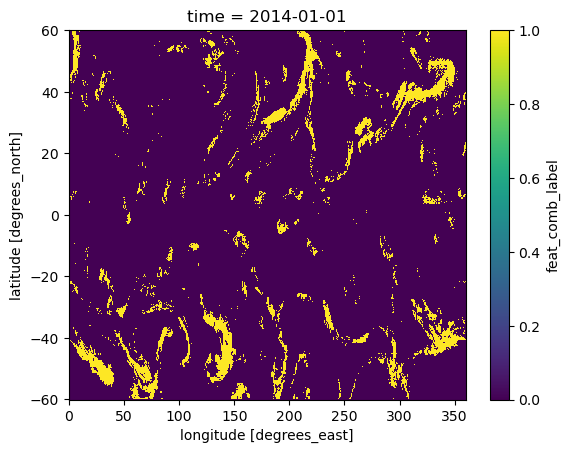

In [36]:
tmp.plot()

In [37]:
# using skimage measure to label connected unions of AR and FT
(label, num) = measure.label(tmp.values, return_num=True, connectivity=2)

In [99]:
%%time
# filtering small areas of rainfall
# get object center to generate geoinfo.nc

parea_threshold = 100
meanlon_list = []
meanlat_list = []
for n in range(1,num+1):
    
    lon_list = []
    lat_list = []
    
    tmp2 = label.copy()
    label_uni = np.where(tmp2 == n, tmp2, 0) # remain the object with the given label number
    idx,idy = np.where(label_uni == n)
    
    if len(idx) > parea_threshold:
        for i,j in zip(idx,idy):
            lon_list.extend([ds_PFID.longitude[j].values])
            lat_list.extend([ds_PFID.latitude[i].values])

        # get geometric centroid 
        meanlon_list.extend([np.mean(lon_list)])
        meanlat_list.extend([np.mean(lat_list)])

CPU times: user 17.4 s, sys: 19.7 ms, total: 17.5 s
Wall time: 18.1 s


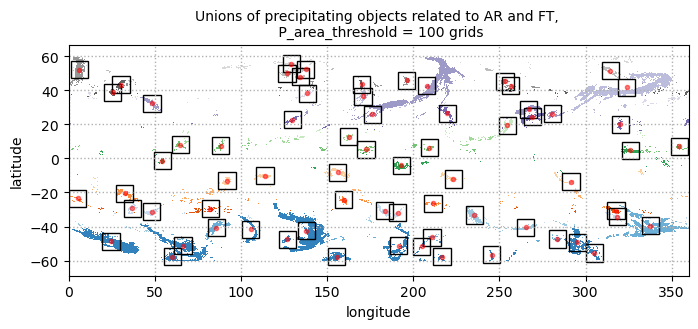

In [111]:
# background: unions of AR and FT
fig,ax = plt.subplots(1,1,figsize=(8,3))

cp = ax.pcolor(ds_PFID.longitude, ds_PFID.latitude, label, cmap='tab20c', vmin=1)
cp.cmap.set_under('w')
# add the geometric centroids
for meanlon, meanlat in zip(meanlon_list, meanlat_list):
    ax.plot(meanlon, meanlat, 'or', ms=3, alpha=0.5)
    rect = Rectangle((meanlon-5,meanlat-5),width=10,height=10,edgecolor='k',facecolor='none')
    ax.add_patch(rect)
    
ax.set_ylabel('latitude',fontsize=10)
ax.set_xlabel('longitude',fontsize=10)
ax.set_title('Unions of precipitating objects related to AR and FT, \n P_area_threshold = 100 grids, 10 x 10 deg. box', fontsize=10)
ax.grid(lw=1,ls=':')
plt.show()
